In [1]:
%load_ext autoreload
%autoreload 2

# Simulate the interaction strengths of different sRNA pairs interacting

## Imports

In [11]:
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import re
import pandas as pd
from subprocess import Popen, PIPE, run
from datetime import datetime

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config, expand_config
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.data.data_format_tools.common import load_multiple_as_list, load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.misc.type_handling import flatten_listlike

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import logging



# Choose sRNA species

In [3]:
fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
d_inter = pd.read_csv(fn_inter)
try:
    d_inter = d_inter.drop(columns=['Unnamed: 0'])
except:
    pass

pattern = r'\s*\([^)]*\)'
for i in [1, 2]:
    d_inter[f'Binding position {i}'] = list(map(lambda raw: flatten_listlike(
        [[[int(re.sub(pattern, '', bp)) for bp in bps.split('..')]
          for bps in re.sub(pattern, '', par).split('; ')] for par in raw if par.split('..')[0].strip('-').isnumeric()]), d_inter[f'Binding position {i}'].apply(str).str.split("'")))

### Write to sRNA

In [4]:
srnas = {}
filt_srna1 = d_inter['Category 1'].isin(['sRNA', 'trans-encoded antisense RNA', 'protein binding small RNA'])
filt_srna2 = d_inter['Category 2'].isin(['sRNA', 'trans-encoded antisense RNA', 'protein binding small RNA']) & (~d_inter['Category 1'].isin(['Protein']))
for i in [1, 2]:
    filt = filt_srna1 if i == 1 else filt_srna2
    for s in d_inter[f'Interactor {i}'].unique():
        seq = d_inter[d_inter[f'Interactor {i}'] == s][f'Sequence {i}'].iloc[0]
        offset = d_inter[d_inter[f'Interactor {i}'] == s][f'Binding position {i}'].iloc[0]
        if offset:
            offset = np.min(offset)
            if offset < 0: 
                seq = d_inter[d_inter[f'Interactor {i}'] == s][f'Sequence before {i}'].iloc[0] + seq
        if s in d_inter[d_inter[f'Category {i}'] == 'mRNA'][f'Interactor {i}'].unique():
            # mrnas[s] = seq.replace('T', 'U').replace('t', 'u')
            pass
        elif s in d_inter[filt][f'Interactor {i}'].unique():
            srnas[s] = seq.replace('T', 'U').replace('t', 'u')
            

In [5]:
config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data": {},
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            # "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "outcsvcols": "id1, id2, E, E_norm, bpList, subseqDB, Pu1, Pu2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}

## Simulate

In [6]:
data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)
circuit = construct_circuit_from_cfg(prev_configs=None, config_file=config_file)

2024-01-31 17:18:25.292182: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
xla_bridge.py:backends():622: Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices. INFO
xla_bridge.py:backends():622: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA INFO
xla_bridge.py:backends():622: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():636: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.) WARNING


In [9]:
sim_data = {}


def simulate_IntaRNA_local(query: dict,
                           targets: dict,
                           sim_kwargs={}):
    fn1 = data_writer.output(data=query, out_type='fasta',
                             out_name='query', byseq=True, return_path=True)
    fn2 = data_writer.output(data=targets, out_type='fasta',
                             out_name='targets', byseq=True, return_path=True)
    sim_kwargs['query'] = fn1
    sim_kwargs['target'] = fn2

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)
    
    os.remove(os.path.join(data_writer.write_dir, 'targets.fasta'))
    os.remove(os.path.join(data_writer.write_dir, 'query.fasta'))

    return run(**sim_kwargs)


t = datetime.now()

sim_data = simulate_IntaRNA_local(query=srnas,
                                     targets=srnas,
                                     sim_kwargs=config_file['interaction_simulator']['simulator_kwargs'])
# print('Finished ', s, ' in ', (datetime.now() - t).total_seconds(), ' s')
logging.warning('Finished ', s, ' in ',
                (datetime.now() - t).total_seconds(), ' s')

data_writer.output(data=sim_data, out_type='json',
                   out_name='inter_data_raw', overwrite=True)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start(

## Turn raw data into table

In [30]:
def create_dict_of_lists(d: dict, col_names: list) -> dict:
    """ GCG """
    result_dict = {field: [] for field in col_names}
    for subdict in d.values():
        for field, value in subdict.items():
            result_dict[field].append(value)

    return result_dict


def swap_ids(d: dict, l1, l2) -> dict:
    if d['id1'][0] != l1:
        for c in ['id', 'Pu']:
            d[f'{c}1_swap'] = d[f'{c}2']
            d[f'{c}2'] = d[f'{c}1']
            d[f'{c}1'] = d[f'{c}1_swap']
            d.pop(f'{c}1_swap', None)
        d['subseqDB'] = list(
            map(lambda x: '&'.join(x.split('&')[::-1]), d['subseqDB']))
    return d


def process_raw_mutation_dict(d: dict) -> dict:
    default_inner = {
        "id1": '',
        "id2": '',
        "E": 0.0,
        "E_norm": 0.0,
        "bpList": '',
        "subseqDB": '',
        "Pu1": 0.0,
        "Pu2": 0.0,
    }

    def make_uniform(d):
        d_new = {}
        for s1, s2s in d.items():
            for s2, v in s2s.items():
                if v == {}:
                    v2 = {k: v for k, v in default_inner.items()}
                else:
                    v2 = v
                d_new['_'.join(sorted([s1, s2]))] = v2
        return d_new
    
    def recast_fields(d):
        for c in ['E', 'E_norm', 'Pu1', 'Pu2']:
            d[c] = list(map(lambda x: float(x), d[c]))
        return d

    d = make_uniform(d)
    d = create_dict_of_lists(d, col_names=list(default_inner.keys()))
    d = recast_fields(d)

    return d

In [31]:
saves = pd.DataFrame()
source_dir = data_writer.write_dir
if os.path.isfile(os.path.join(source_dir, 'inter_data_raw.json')):
    d = load_json_as_dict(os.path.join(source_dir, 'inter_data_raw.json'))
d = process_raw_mutation_dict(sim_data)
d = pd.DataFrame(d)
saves = pd.concat([saves, d])

    

In [33]:
saves.to_csv('data/03_simulate_sRNA_confusion/2024_01_31_171825/tabulated_mutation_info.csv')

In [8]:
# modeller = CircuitModeller(result_writer=data_writer, config=config_file)
# circuits = modeller.batch_circuits(
#     circuits=[circuit],
#     write_to_subsystem=True, batch_size=config_file['simulation'].get('batch_size', 100),
#     methods={
#         "compute_interactions": {},
#         # "init_circuits": {'batch': True},
#         # "simulate_signal_batch": {'ref_circuit': None,
#         #                           'batch': True},
#         "write_results": {'no_visualisations': config_file['experiment'].get('no_visualisations', True),
#                           'no_numerical': config_file['experiment'].get('no_numerical', False)}
#     })

# Visualise

### Reload saves

In [43]:
# saves = pd.read_csv('data/03_simulate_sRNA_confusion/2024_01_21_234310/tabulated_mutation_info.csv')
saves = pd.read_csv('data/03_simulate_sRNA_confusion/2024_01_31_171825/tabulated_mutation_info.csv')
saves.drop(columns=['Unnamed: 0'], inplace=True)

In [44]:
saves

id1    id2      E    E_norm  \
0     dsrA   ryhB  -2.17 -0.242033   
1     sgrS   ryhB  -6.14 -0.618655   
2     sdsR   ryhB  -1.13 -0.121563   
3     istR   ryhB  -3.47 -0.367528   
4     omrA   ryhB  -2.65 -0.295194   
..     ...    ...    ...       ...   
533   AfaR   mntS  -9.22 -0.893832   
534  Esr41   mntS  -0.51 -0.055653   
535   AfaR   AfaR -11.90 -1.090680   
536  Esr41   AfaR  -3.17 -0.324816   
537  Esr41  Esr41  -6.36 -0.738836   

                                                bpList  \
0    (40,12):(41,11):(42,10):(43,9):(44,8):(45,7):(...   
1    (57,46):(58,45):(59,44):(60,43):(61,42):(63,40...   
2    (43,61):(44,60):(45,59):(46,58):(47,57):(48,56...   
3    (62,44):(63,43):(64,42):(65,41):(66,40):(67,39...   
4    (4,67):(5,66):(7,64):(8,63):(9,62):(10,61):(11...   
..                                                 ...   
533  (74,40):(75,39):(76,38):(77,37):(78,36):(79,35...   
534  (49,89):(50,88):(51,87):(52,86):(53,85):(54,84...   
535  (9,168):(10,167):(11,166):(12,165):(14,163):(1...   
536  (52,129):(53,128):(54,127):(55,126):(56,125):(...   
537  (23,32):(24,31):(25,30):(26,29):(27,28):(28,27...   

                                              subseqDB       Pu1           Pu2  
0                                   40CUUCUUG&6CAGGAAG  0.014250  1.448260e-02  
1                    57AGCGAAGUUGUGCU&33AGCACGACAUUGCU  0.000059  1.268380e-04  
2                                  43ACUGGAA&55UUCCAGU  0.000113  3.833900e-02  
3                                62CAGUGUUG&37CGACAUUG  0.005933  1.547550e-01  
4                             4AGAGGUAUUG&58CAGUAUUACU  0.514151  1.598590e-01  
..                                                 ...       ...           ...  
533  74AAUGGCUAUAUACGGCACUCAGUUUACACUU&16AGGUGUAUGC...  0.000860  1.559620e-07  
534                                49ACUAUGU&83AUAUGGU  0.015707  6.549030e-02  
535            9UAUGUUCCAUAACAGAC&152GUCUGUUGUGGACCAUA  0.194221  9.756170e-07  
536                               52AUGUGUU&123AACACAU  0.015707  6.774580e-01  
537                          23CUCCAUGGGG&23CUCCAUGGGG  0.000300  2.997210e-04  

[538 rows x 8 columns]

In [36]:
# source_dirs = [data_writer.top_write_dir]
# source_dirs = ['data/tests/2023_11_03_104039/']
# source_dirs = ['data/03_simulate_sRNA_confusion/2024_01_21_234310/']
# tables = load_multiple_as_list(inputs_list=source_dirs, load_func=b_tabulate_mutation_info, 
#             data_writer=data_writer)
# saves = pd.concat(tables, axis=0)
# saves['path_to_template_circuit'] = circuit_fasta
# source_dirs

In [46]:
def make_symmetrical_matrix_from_sequence(arr, side_length: int):
    """ For a flat 1D array, make a symmetrical 2D matrix filling
    in the upper triangle with the 1D array. """
    i = np.triu(
        np.arange(side_length * side_length).reshape(side_length, side_length))
    ii = i + i.T - np.diag(i.diagonal())
    return arr[ii.flatten()].reshape(side_length, side_length)


In [48]:
slengths = np.array([len(srnas[k]) for k in sorted(srnas.keys())])
e = saves['E'].values.squeeze()
e = make_symmetrical_matrix_from_sequence(e, side_length=len(srnas))
e_norm = e / (slengths * np.ones_like(e))

IndexError: index 538 is out of bounds for axis 0 with size 538

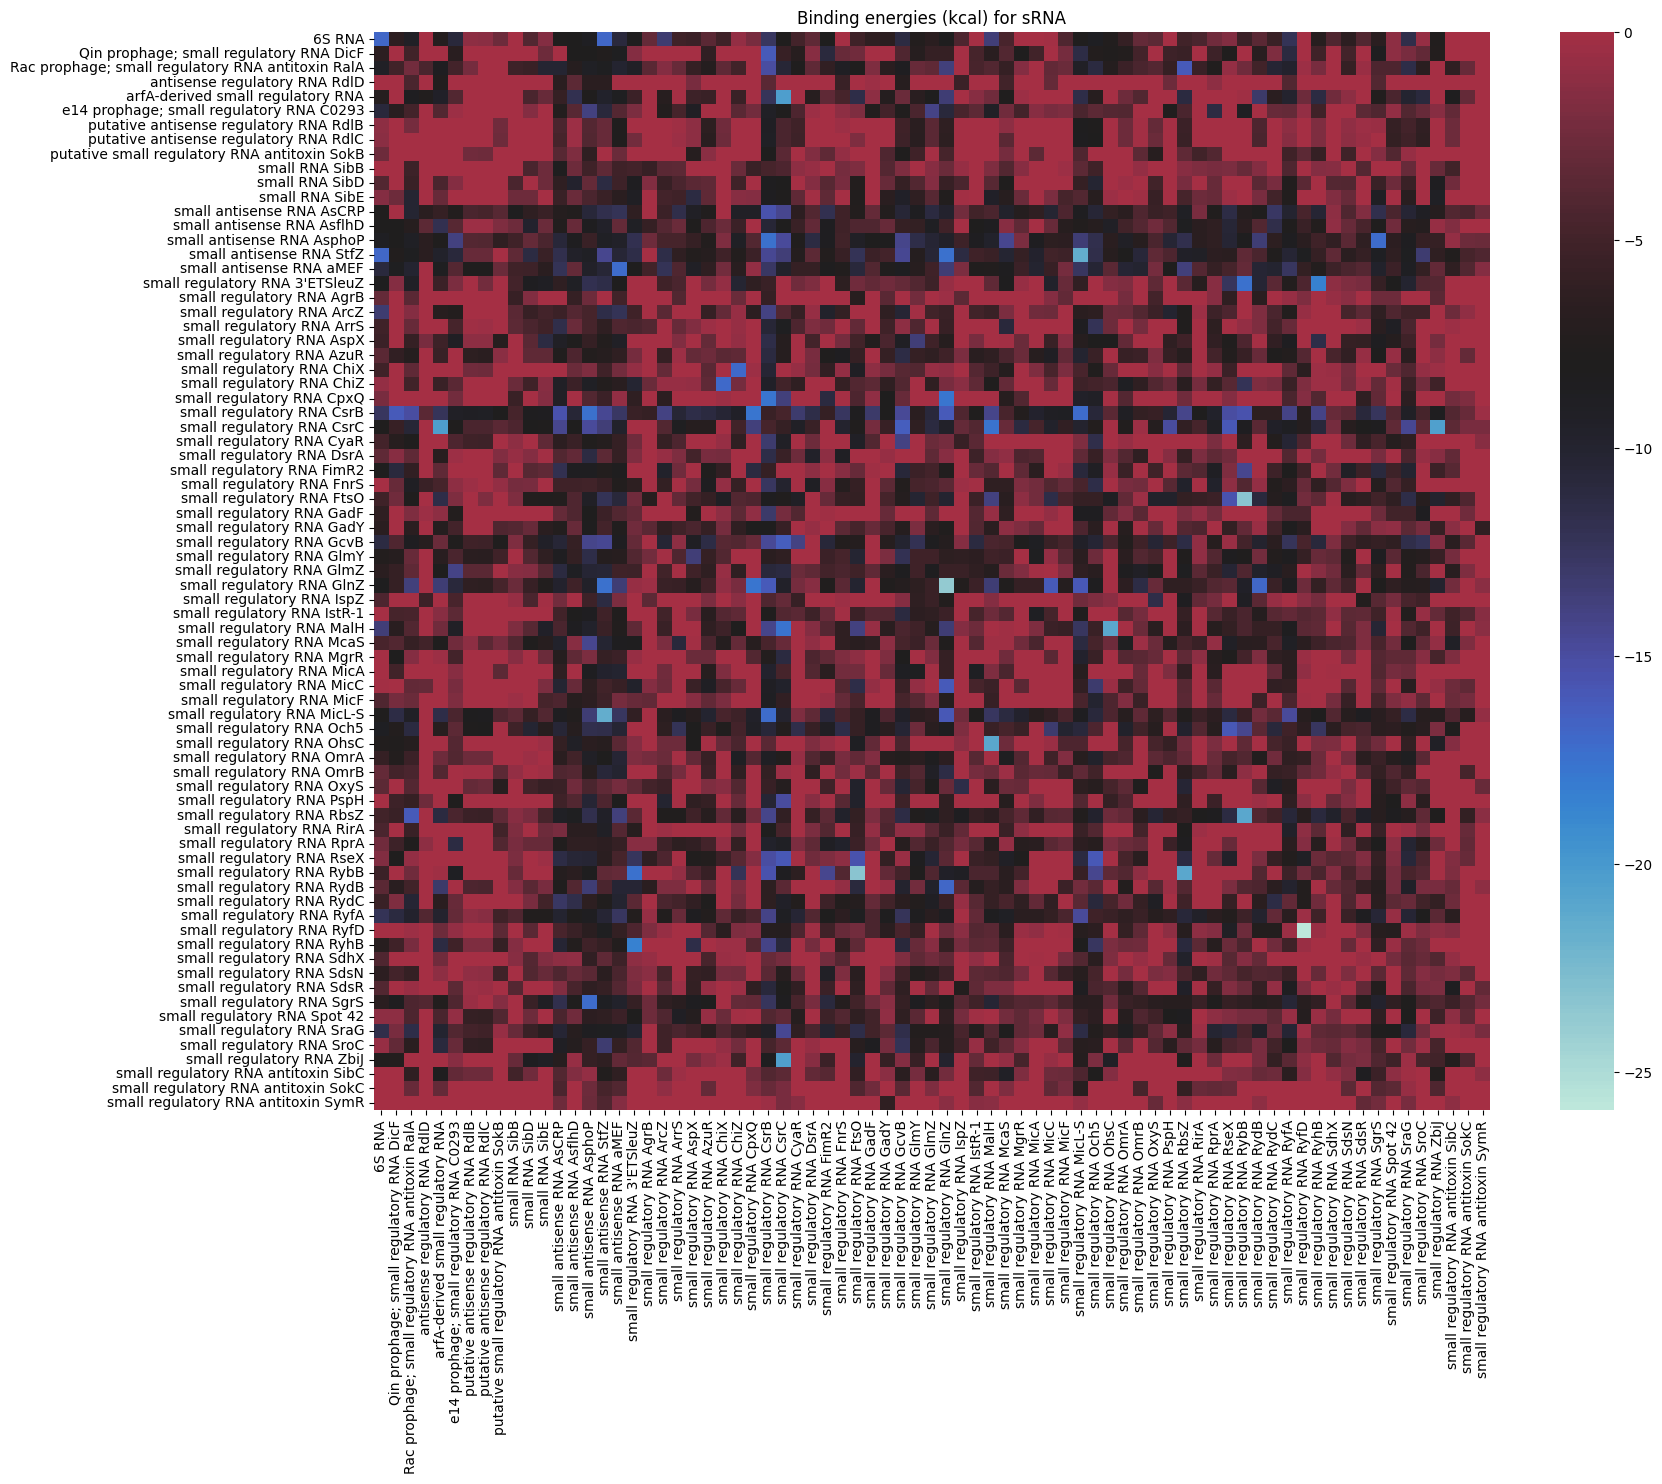

In [17]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(e,
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d),  
            center=-8)  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Binding energies (kcal) for sRNA')
plt.savefig('data/figs/confusion_sRNA.jpg')

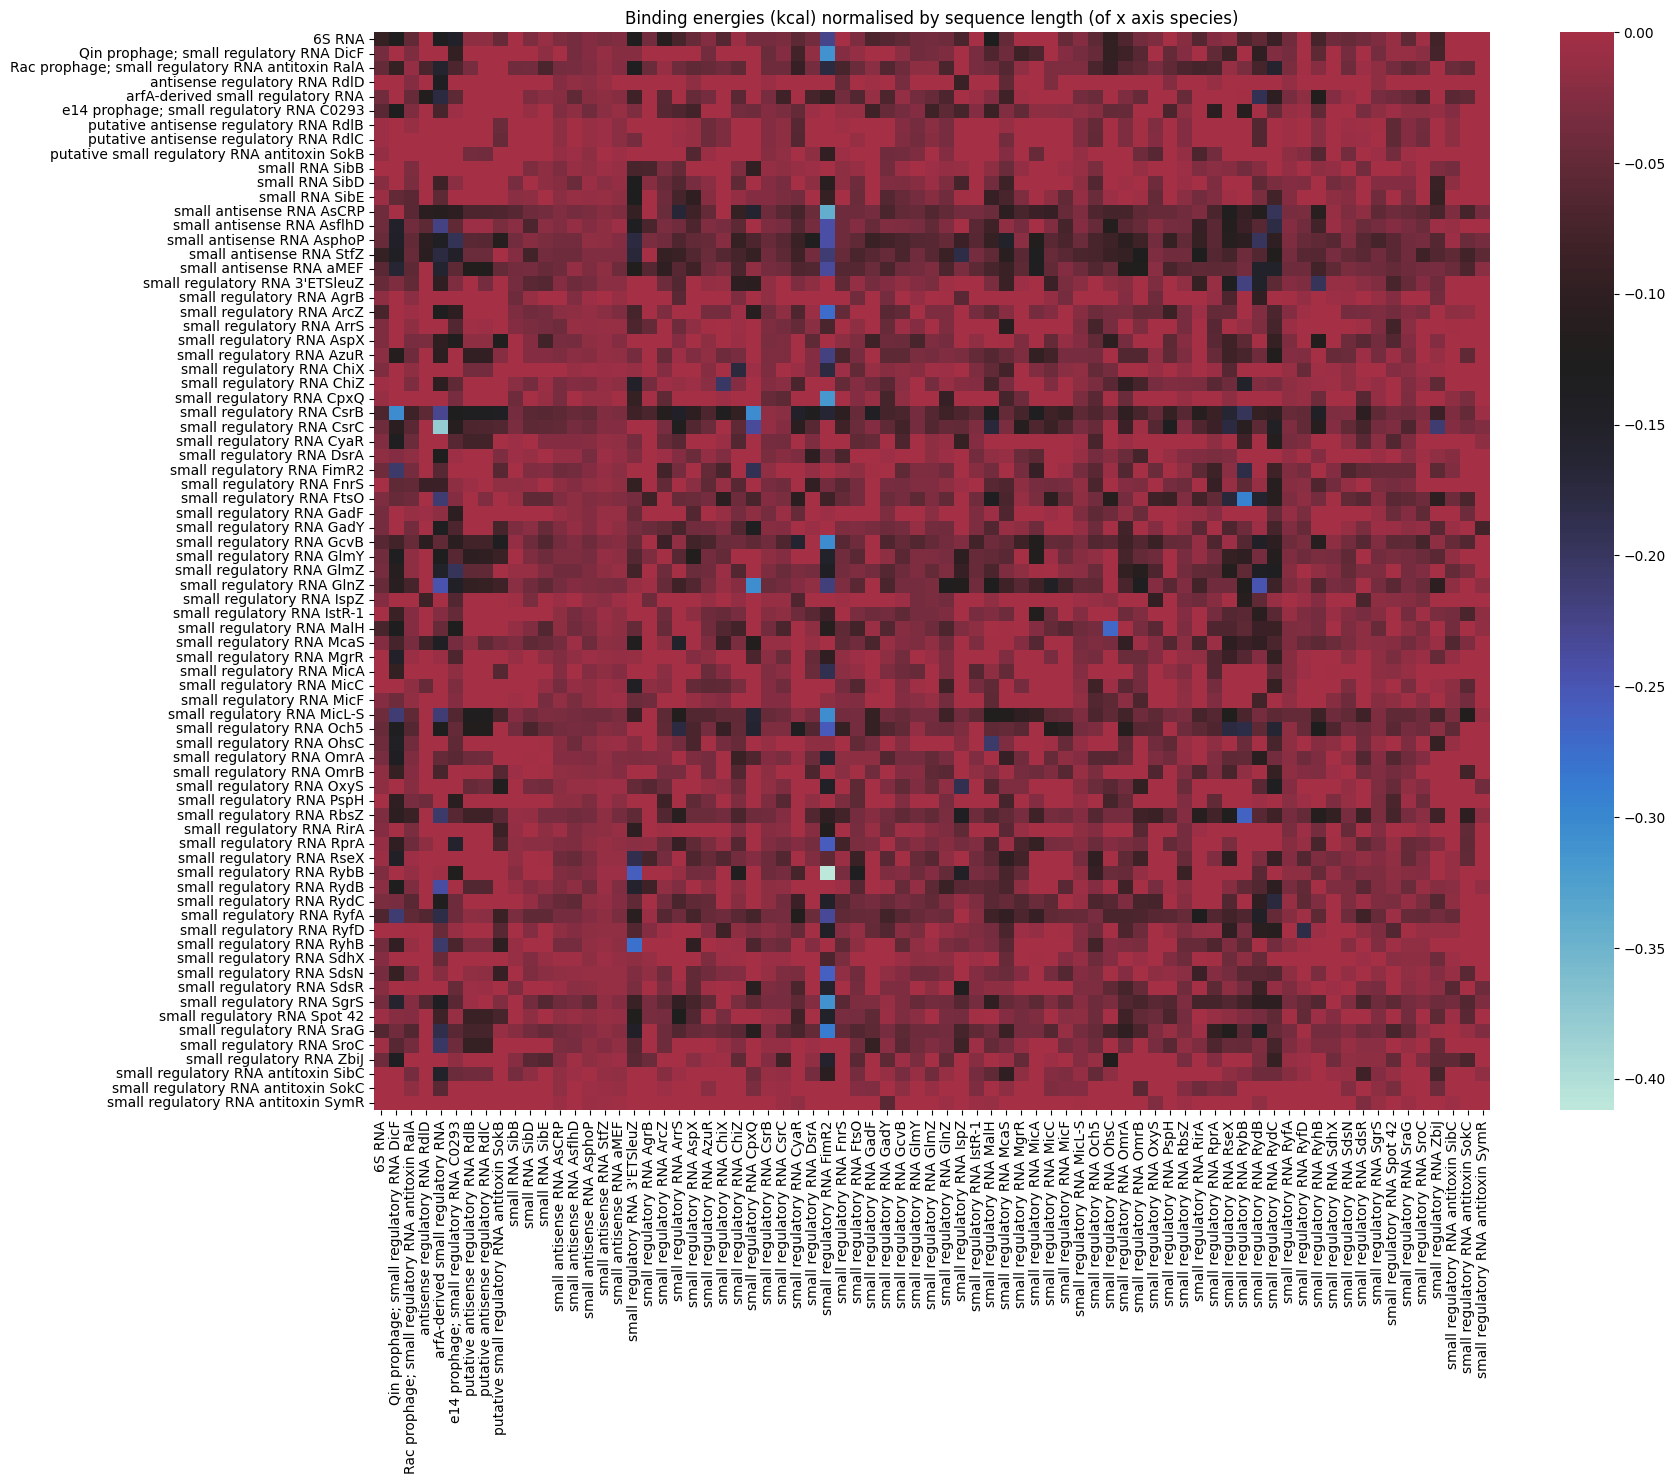

In [18]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(e_norm,
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d),
            center=-8 / e.min() * e_norm.min())  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Binding energies (kcal) normalised by sequence length (of x axis species)')
plt.savefig('data/figs/confusion_sRNA_norm.jpg')


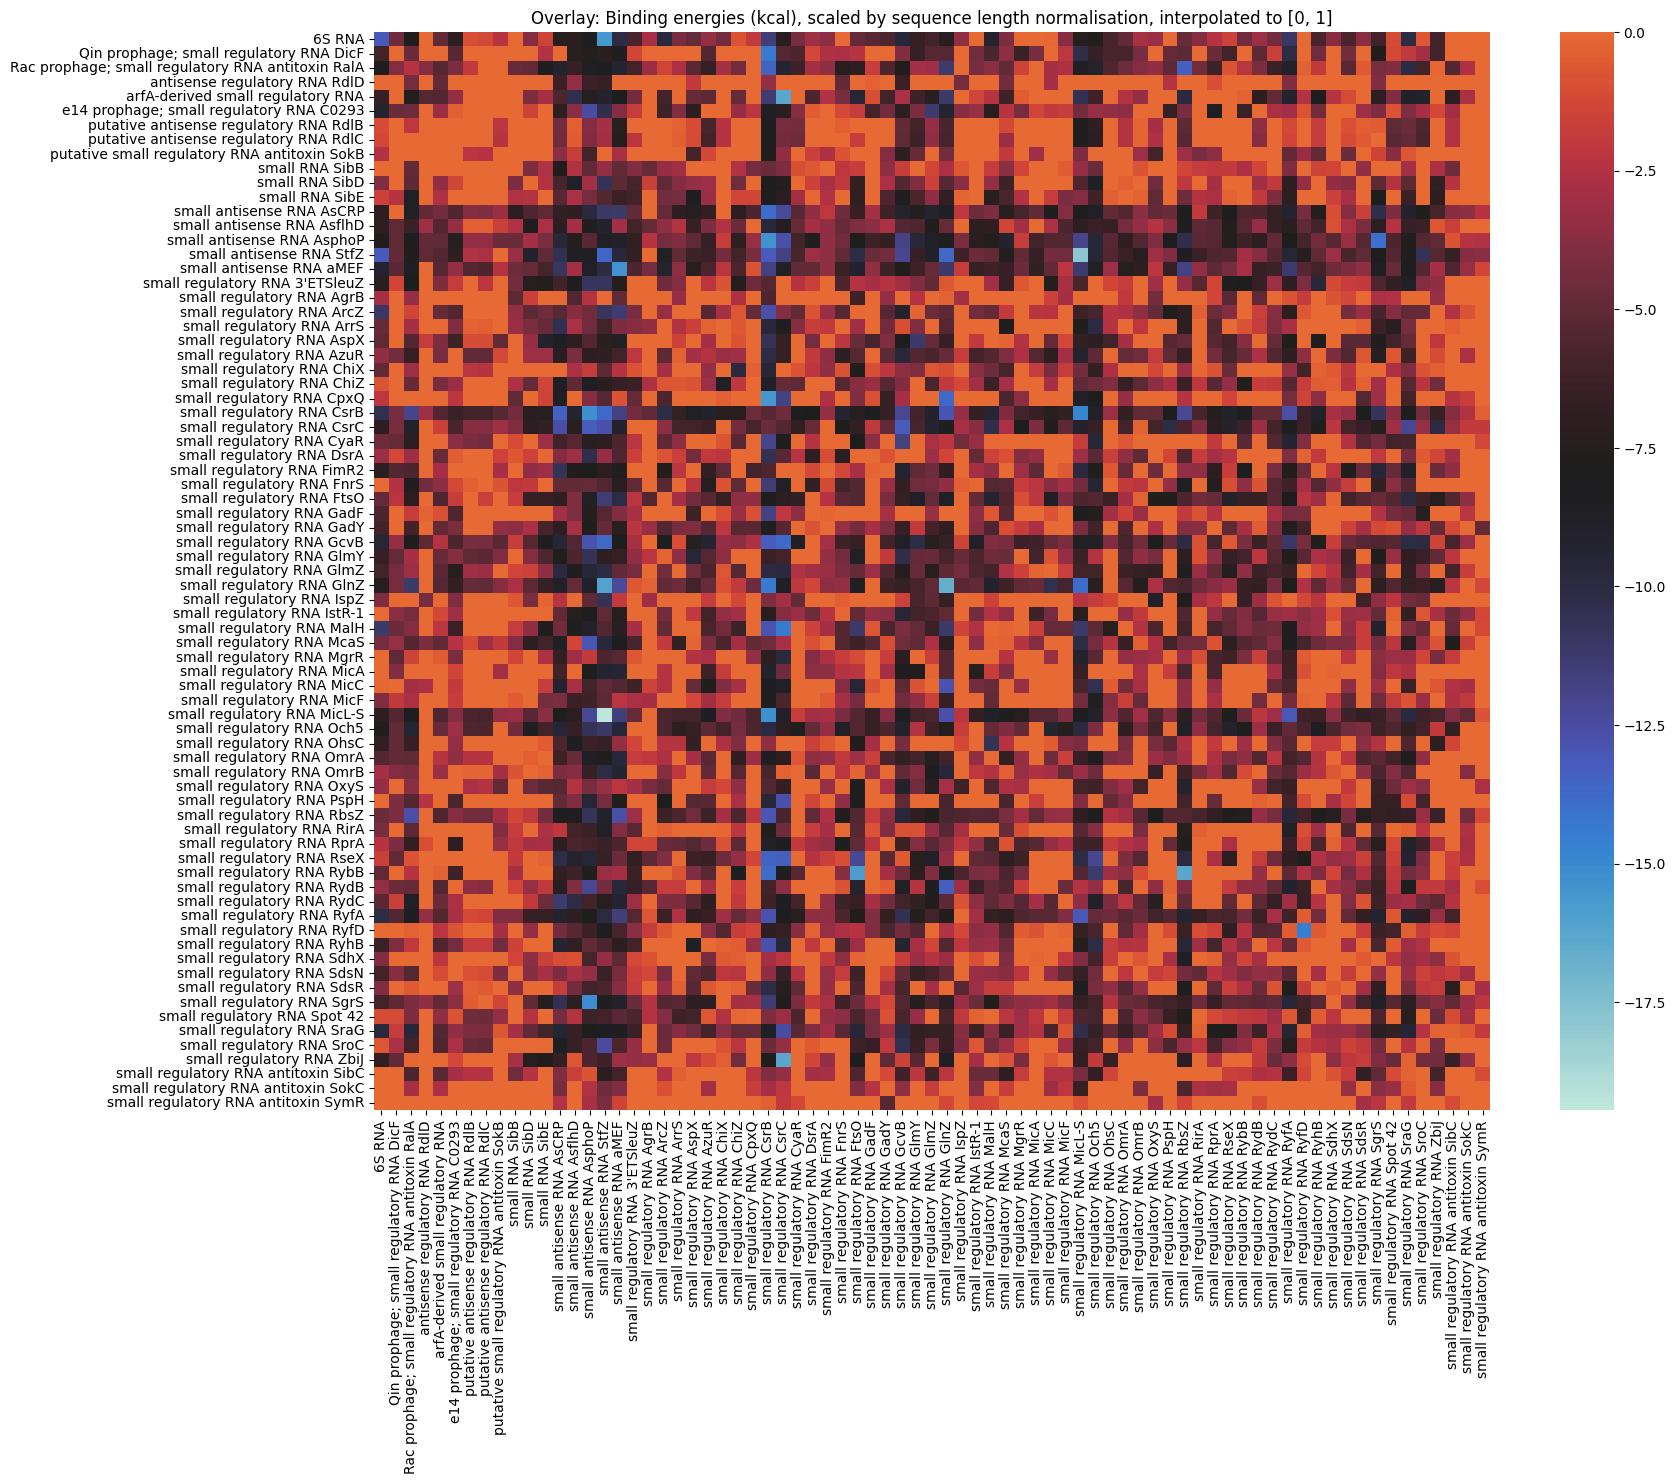

In [19]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(e * np.interp(e_norm, [e_norm.min(), e_norm.max()], [0, 1]),
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d), 
            center = -8)  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Overlay: Binding energies (kcal), scaled by sequence length normalisation, interpolated to [0, 1]')
plt.savefig('data/figs/confusion_sRNA_len-norm.jpg')


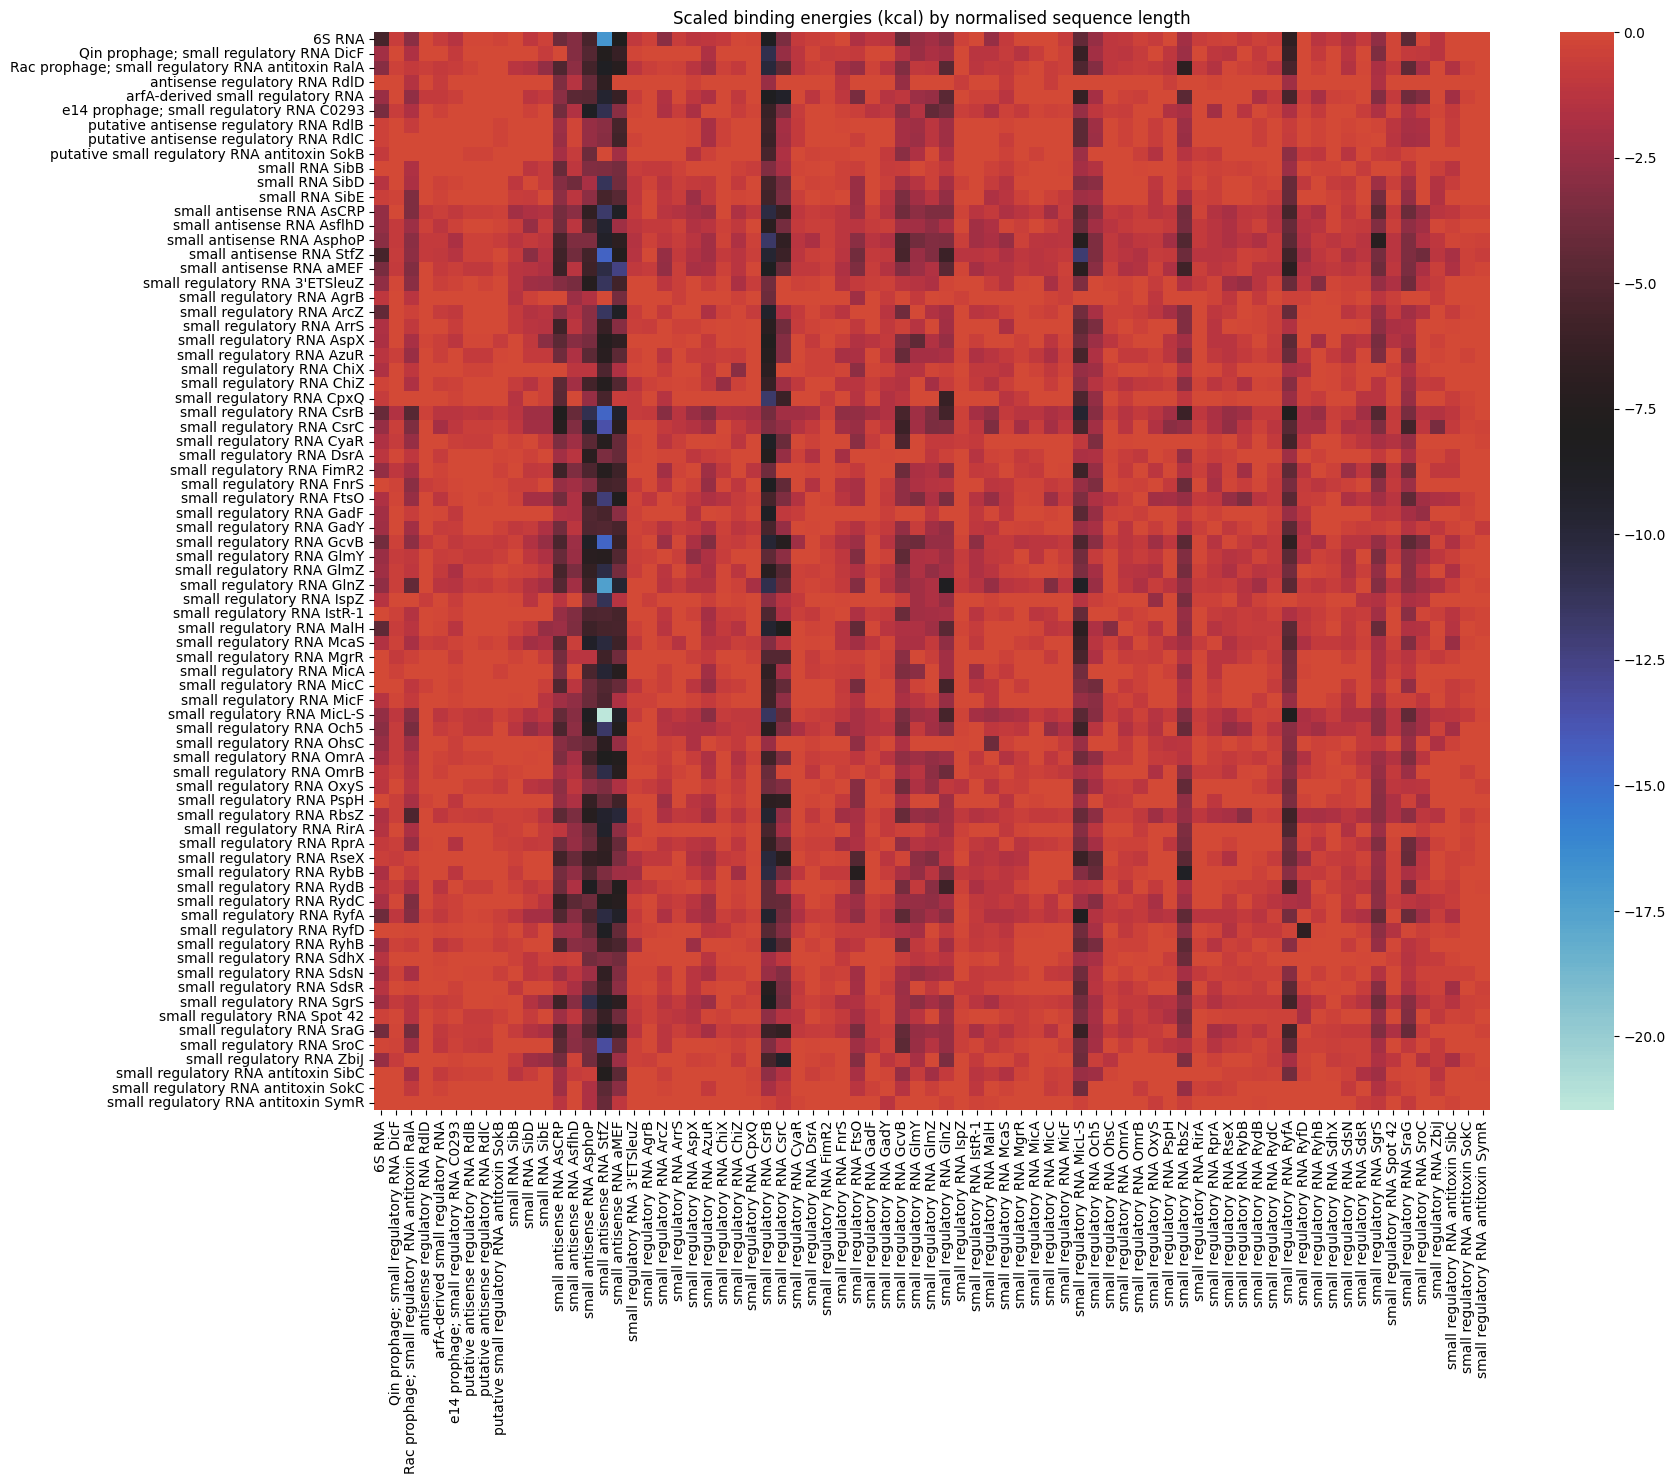

In [20]:
s = (slengths * np.ones_like(e)) / (slengths * np.ones_like(e)).max()

fig = plt.figure(figsize=(18, 14))
sns.heatmap(e * s,
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d), 
            center = -8)  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Scaled binding energies (kcal) by normalised sequence length')

plt.savefig('data/figs/confusion_sRNA_len-norm2.jpg')
